In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, log_loss
import matplotlib.pyplot as plt
import random
from typeguard import typechecked

In [2]:
random.seed(42)
np.random.seed(42)

###############
###############
# Q1
###############
###############

In [3]:
from typing import Tuple


@typechecked
def read_classification_data(file_path: str) -> Tuple[np.array, np.array]:
	'''
		Read the data from the path.
		Return the data as 2 np arrays each with shape (number_of_rows_in_dataframe, 1)
		Order (np.array from first row), (np.array from second row)
	'''
	df: pd.DataFrame = pd.read_csv(file_path, header=None)
	X: np.ndarray = df.iloc[:, 0].to_numpy().reshape(-1, 1)[:2, :]
	y: np.ndarray = df.iloc[:, 1].to_numpy().reshape(-1, 1)[:2, :]
	return X, y


In [4]:
@typechecked
def sigmoid(s: np.array) -> np.array:
    '''
    	Return the sigmoid of every number in the array s as an array of floating point numbers
    	sigmoid(s)= 1/(1+e^(-s))
    '''
    return 1 / (1 + np.exp(-s))


In [5]:
@typechecked
def cost_function(w: float, b: float, X: np.array, y: np.array) -> float:
    '''
		Inputs definitions:
			w : weight
			b : bias
			X : input  with shape (number_of_rows_in_dataframe, 1)
			y : target with shape (number_of_rows_in_dataframe, 1)
		Return the loss as a float data type. 
    '''
    n = len(y)
    y_pred = sigmoid(np.dot(X, w) + b)
    loss = -np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)) / n
    return loss


In [6]:
@typechecked
def cross_entropy_optimizer(w: float, b: float, X: np.array, y: np.array, num_iterations: int, alpha: float) -> Tuple[float, float, list]:
    '''
        Inputs definitions:
            w              : initial weight
            b              : initial bias
            X              : input  with shape (number_of_rows_in_dataframe, 1)
            y              : target with shape (number_of_rows_in_dataframe, 1)
            num_iterations : number of iterations 
            alpha          : Learning rate

        Task: Iterate for given number of iterations and find optimal weight and bias 
        while also noting the change in cost/ loss after every iteration

        Make use of the cost_function() above

        Return (updated weight, updated bias, list of "costs" after each iteration) in this order
        "costs" list contains float type numbers  
    '''
    costs = []
    weight: float = w
    offset: float = b
    for i in range(num_iterations):
        y_pred = sigmoid(np.dot(X, w) + b)
        dw: float = np.dot(X.T, (y_pred - y)) / len(y)
        db: float = np.sum(y_pred - y) / len(y)
        weight -= float(alpha * dw)
        offset -= float(alpha * db)
        cost = cost_function(weight, offset, X, y)
        costs.append(cost)
    return weight, offset, costs


###############
###############
# Q3 a
###############
###############

In [7]:
@typechecked
def read_sat_image_data(file_path: str) -> pd.DataFrame:
    '''
		  Input: filepath to a .csv file
		  Output: Return a DataFrame with the data from the given csv file 
    '''
    return pd.read_csv(file_path)


In [8]:
@typechecked
def remove_nan(df: pd.DataFrame) -> pd.DataFrame:
    '''
    	Remove nan values from the dataframe and return it
    '''
    return df.dropna()


In [9]:
@typechecked
def normalize_data(Xtrain: pd.DataFrame, Xtest: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
	'''
		Normalize each column of the dataframes and Return the dataframes
		Use sklearn.preprocessing.StandardScaler library to normalize
		Return the results in the order Xtrain_norm, Xtest_norm
	'''
	scaler = StandardScaler()
	Xtrain_norm = pd.DataFrame(scaler.fit_transform(Xtrain), columns=Xtrain.columns)
	Xtest_norm = pd.DataFrame(scaler.transform(Xtest), columns=Xtest.columns)
	return Xtrain_norm, Xtest_norm


In [10]:
@typechecked
def labels_to_binary(y: pd.DataFrame) -> pd.DataFrame:
    '''
    Make the lables [1,2,3,4,5] as 0 and [6] as 1
    Return the DataFrame 
    '''
    # Create a copy of the original DataFrame to avoid modifying it
    y_binary: pd.DataFrame = y.copy()
    
    y_binary.loc[y_binary["Class"].isin([1,2,3,4,5]), "Class"] = 0
    y_binary.loc[y_binary["Class"] == 6, "Class"] = 1
    
    # Return the modified DataFrame
    return y_binary


###############
###############
# Q3 b
###############
###############

In [11]:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

@typechecked
def cross_validate_c_vals(X: pd.DataFrame, y: pd.DataFrame, n_folds: int, c_vals: np.array, d_vals: np.array) -> Tuple[np.array, np.array]:
	'''
		Return the matrices (ERRAVGdc, ERRSTDdc) in the same order
		More details about the imlementation are provided in the main function
	'''
	ERRAVGdc = np.zeros((len(c_vals), len(d_vals)))
	ERRSTDdc = np.zeros((len(c_vals), len(d_vals)))

	for i, c in enumerate(c_vals):
		for j, d in enumerate(d_vals):
			fold_errors = np.zeros(n_folds)
			svr = SVR(kernel='sigmoid', degree=d, C=c)

			kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

			for k, (train_indices, test_indices) in enumerate(kfold.split(X, y)):
				X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
				X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

				svr.fit(X_train, y_train.values.ravel())
				y_pred = svr.predict(X_test)
				fold_errors[k] = mean_absolute_error(y_test, y_pred)

			ERRAVGdc[i, j] = np.mean(fold_errors)
			ERRSTDdc[i, j] = np.std(fold_errors)

	return ERRAVGdc, ERRSTDdc

In [12]:
@typechecked
def plot_cross_val_err_vs_c(ERRAVGdc: np.array, ERRSTDdc: np.array, c_vals: np.array, d_vals: np.array) -> None:
    '''
     Please write the code in below block to generate the graphs as described in the question.
     Note that the code will not be graded, but the graphs submitted in the report will be evaluated.
    '''
    fig, axs = plt.subplots(len(d_vals), sharex=True, sharey=True, figsize=(10, 10))
    fig.suptitle('Cross Validation Errors vs. C')

    for d_idx, d in enumerate(d_vals):
        axs[d_idx].errorbar(c_vals, ERRAVGdc[:,d_idx], yerr=ERRSTDdc[:,d_idx], fmt='o-', capsize=5)
        axs[d_idx].set_xscale('log')
        axs[d_idx].set_xlabel('C')
        axs[d_idx].set_ylabel(f'Degree {d} Error')

    plt.tight_layout()
    plt.show()


###############
###############
# Q3 c
###############
###############

In [13]:
@typechecked
def evaluate_c_d_pairs(X_train: pd.DataFrame, y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame, n_folds: int, c_vals: np.array, d_vals: np.array) -> Tuple[np.array, np.array, np.array, np.array]:
	'''
		Return in the order: ERRAVGdcTEST, SuppVect, vmd, MarginT
		Below are the vectors evaluated by evaluate_c_d_pairs() function
			ERRAVGdcTEST - Average Testing error for each value of 'd'
			SuppVect     - Average Number of Support Vectors for each value of 'd'
			vmd          - Average Number of Support Vectors that Violate the Margin for each value of 'd'
			MarginT      - Average Value of Hyperplane Margins for each value of 'd'
		Shape:
			ERRAVGdcTEST = np array with shape len(d_vals)
			SuppVect     = np array with shape len(d_vals)
			vmd          = np array with shape len(d_vals)
			MarginT      = np array with shape len(d_vals)
	'''
	d_val_len = len(d_vals)
	ERRAVGdcTEST = np.zeros(d_val_len)
	SuppVect = np.zeros(d_val_len)
	vmd = np.zeros(d_val_len)
	MarginT = np.zeros(d_val_len)
	
	for d_idx, d in enumerate(d_vals):
		ERRc = []
		SuppVectc = []
		vmdc = []
		MarginTc = []
		for c in c_vals:
			svm = SVC(kernel='poly', degree=d, C=c)
			errc = []
			supvectc = []
			vmdcc = []
			marginTc = []
			for fold in range(n_folds):
				start = fold * (len(X_train) // n_folds)
				end = (fold + 1) * (len(X_train) // n_folds)
				X_val = X_train[start:end]
				y_val = y_train[start:end]
				X_train_folds = pd.concat([X_train[:start], X_train[end:]])
				y_train_folds = pd.concat([y_train[:start], y_train[end:]])
				
				svm.fit(X_train_folds, y_train_folds.values.ravel())
				y_pred = svm.predict(X_val)
				err = mean_absolute_error(y_val, y_pred)
				errc.append(err)
				supvectc.append(np.sum(svm.n_support_))
				vmdcc.append(np.sum(np.abs(svm.decision_function(X_val)) <= 1))
				marginTc.append(np.mean(np.abs(svm.decision_function(X_val))))
			
			ERRc.append(np.mean(errc))
			SuppVectc.append(np.mean(supvectc))
			vmdc.append(np.mean(vmdcc))
			MarginTc.append(np.mean(marginTc))
		
		ERRAVGdcTEST[d_idx] = np.min(ERRc)
		SuppVect[d_idx] = np.mean(SuppVectc)
		vmd[d_idx] = np.mean(vmdc)
		MarginT[d_idx] = np.mean(MarginTc)
	
	return ERRAVGdcTEST, SuppVect, vmd, MarginT


In [14]:
@typechecked
def plot_test_errors(ERRAVGdcTEST: np.array, d_vals: np.array) -> None:
    '''
     Please write the code in below block to generate the graphs as described in the question.
     Note that the code will not be graded, but the graphs submitted in the report will be evaluated.
    '''
    plt.plot(d_vals, ERRAVGdcTEST, '-o')
    plt.title('Average Testing Error vs. Polynomial Kernel Degree')
    plt.xlabel('Degree of Polynomial Kernel')
    plt.ylabel('Average Testing Error')
    plt.xticks(d_vals)
    plt.show()


################
################
# Q3 d
################
################

In [15]:
@typechecked
def plot_avg_support_vec(SuppVect: np.array, d_vals: np.array) -> None:
	'''
		Please write the code in below block to generate the graphs as described in the question.
		Note that the code will not be graded, but the graphs submitted in the report will be evaluated.
	'''
	fig, ax = plt.subplots()
	ax.plot(d_vals, SuppVect, '-o')
	ax.set_xlabel('d')
	ax.set_ylabel('Average number of support vectors')
	ax.set_title('Average number of support vectors vs. d')

	# Set the x and y limits for the plot
	ax.set_ylim([np.min(SuppVect) * 0.99, np.max(SuppVect) * 1.01])

	plt.show()


In [16]:
@typechecked
def plot_avg_violating_support_vec(vmd: np.array, d_vals: np.array) -> None:
	'''
		Please write the code in below block to generate the graphs as described in the question.
		Note that the code will not be graded, but the graphs submitted in the report will be evaluated.
	'''
	fig, ax = plt.subplots()
	ax.plot(d_vals, vmd, '-o')
	ax.set_xlabel('d')
	ax.set_ylabel('Average number of support vectors')
	ax.set_title('Average number of support vectors vs. d')

	# Set the x and y limits for the plot
	ax.set_ylim([np.min(vmd) * 0.99, np.max(vmd) * 1.01])
 
	plt.show()


################
################
# Q3 e
################
################

In [17]:
@typechecked
def plot_avg_hyperplane_margins(MarginT: np.array, d_vals: np.array) -> None:
	'''
		Please write the code in below block to generate the graphs as described in the question.
		Note that the code will not be graded, but the graphs submitted in the report will be evaluated.
	'''
	plt.plot(d_vals, MarginT, '-o')
	plt.xlabel('Degree of Polynomial Kernel')
	plt.ylabel('Average Margin of Hyperplane')
	plt.title('Average Margin of Hyperplane vs Degree of Polynomial Kernel')
	plt.show()


# General Instructions
If you want to use a library which is not already included at the top of this file,
import them in the function in which you are using the library, not at the top of this file.
If you import it at the top of this file, your code will not be evaluated correctly by the autograder.
You will not be awarded any points if your code fails because of this reason.

Weignt W:  2.036175333343037
Bias b:  -17.969734432950276


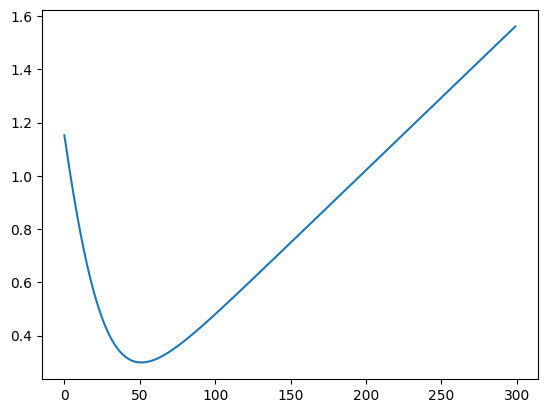

In [18]:
################
################
# Q1
################
################

'''
	Below we load the data.
	Provide the path for data.
	Implement- read_classification_data()
'''
classification_data_2d_path = "./2d_classification_data_entropy.csv"
x, y = read_classification_data(classification_data_2d_path)

'''
    Below code initializes the weight and bias to 1, then iterates 300 times to find a better fit. 
    The cost/error is plotted against the number of iterations. 
    Please submit a screenshot of the plot in the report to receive points. 
    Implement- sigmoid(), cost_function(), cross_entropy_optimizer()
'''

w: float = 1.0
b: float = 1.0
num_iterations: int = 300
w, b, costs = cross_entropy_optimizer(w, b, x, y, num_iterations, 0.1)
print("Weignt W: ", w)
print("Bias b: ", b)
plt.plot(range(num_iterations), costs)
plt.show()

################
################
# Q3 a
################
################

In [19]:
'''
Below we load the data into dataframe.
Provide the path for training and test data.
Implement- read_sat_image_data()
'''

sat_image_Training_path = "./satimageTraining.csv"
sat_image_Test_path = "./satimageTest.csv"

train_df = read_sat_image_data(sat_image_Training_path)  # Training set
test_df = read_sat_image_data(sat_image_Test_path)  # Testing set

'''
Below code 
-removes nan values from data frame
-loads the train and test dataframes
-Normalize the input dataframes
-convert labels to binary
Implement- remove_nan(), normalize_data(), labels_to_binary()
'''
train_df_nan_removed = remove_nan(train_df)
test_df_nan_removed = remove_nan(test_df)

ytrain = train_df_nan_removed[['Class']]
Xtrain = train_df_nan_removed.drop(['Class'], axis=1)

ytest = test_df_nan_removed[['Class']]
Xtest = test_df_nan_removed.drop(['Class'], axis=1)

Xtrain_norm, Xtest_norm = normalize_data(Xtrain, Xtest)

ytrain_bin_label = labels_to_binary(ytrain)
ytest_bin_label = labels_to_binary(ytest)

################
################
# Q3 b
################
################

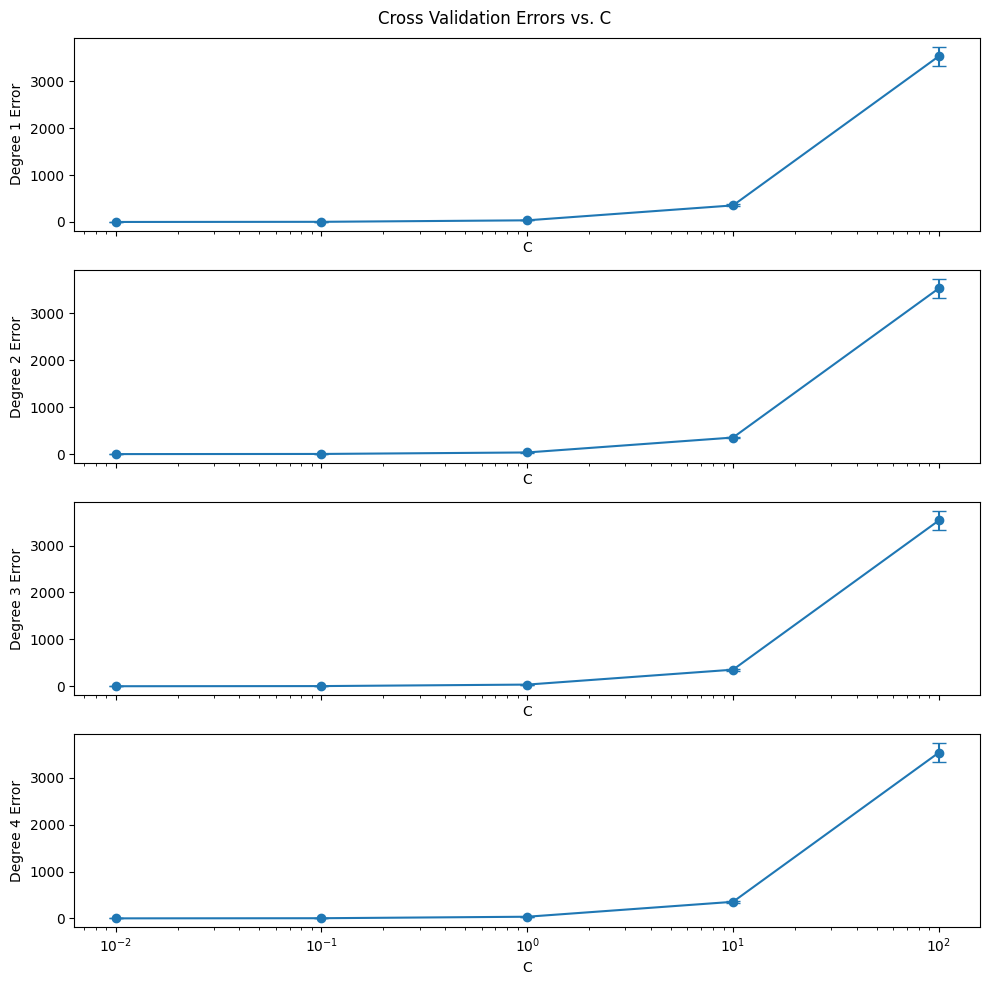

In [20]:
'''
ERRAVGdc is a matrix with ERRAVGdc[c][d] = "Average Mean Absolute Error" of 10 folds for 'C'=c and degree='d'
ERRSTDdc is a matrix with ERRSTDdc[c][d] = "Standard Deviation" of 10 folds for 'C'=c and degree='d'
Both the matrices have size (len(c_vals), len(d_vals))
Fill these matrices in the cross_validate_c_vals function
For each 'c' and 'd' values :
Split the data into 10 folds and for each fold:
	Find the predictions and corresponding mean Absolute errors and store the error
Evaluate the "Average Mean Absolute Error" and "Standard Deviation" from stored errors
Update the ERRAVGdc[c][d], ERRSTDdc[c][d] with the evaluated "Average Mean Absolute Error" and "Standard Deviation"
	
Note: 'C' is the trade-off constant, which controls the trade-off between a smooth decision boundary and classifying the training points correctly.
Note: 'degree' is the degree of the polynomial kernel used with the SVM
Matrices ERRAVGdc, ERRSTDdc look like this:
		d=1   d=2   d=3   d=4
--------- ---   ---   ---   --- 
c=0.01 | .     .     .     .
c=0.1  | .     .     .     .
c=1    | .     .     .     .
c=10   | .     .     .     .
c=100  | .     .     .     .

Implement- cross_validate_c_vals(), plot_cross_val_err_vs_c()
'''
c_vals = np.power(float(10), range(-2, 2 + 1))
n_folds = 5
d_vals = np.array([1, 2, 3, 4])

ERRAVGdc, ERRSTDdc = cross_validate_c_vals(
	Xtrain_norm, ytrain_bin_label, n_folds, c_vals, d_vals)

plot_cross_val_err_vs_c(ERRAVGdc, ERRSTDdc, c_vals, d_vals)

################
################
# Q3 c
################
################

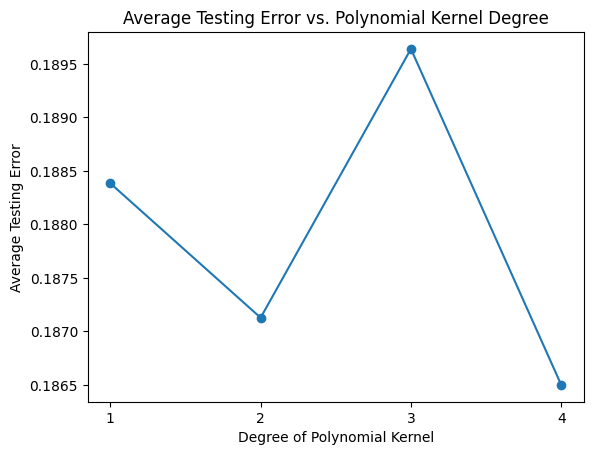

In [21]:
d_vals = [1, 2, 3, 4]
n_folds = 5
'''
Use the results from above and Fill the best c values for d=1,2,3,4
'''
new_c_vals = [10 ** -2, 10 ** -2, 10 ** -2, 10 ** -2]


'''
Below are the vectors evaluated by evaluate_c_d_pairs() function
ERRAVGdcTEST - Average Testing error for each value of 'd'
SuppVect     - Average Number of Support Vectors for each value of 'd'
vmd          - Average Number of Support Vectors that Violate the Margin for each value of 'd'
MarginT      - Average Value of Hyperplane Margins for each value of 'd'
Implement- evaluate_c_d_pairs(), plot_test_errors, plot_avg_support_vec(), plot_avg_violating_support_vec(), plot_avg_hyperplane_margins()
'''

ERRAVGdcTEST, SuppVect, vmd, MarginT = evaluate_c_d_pairs(
	Xtrain_norm, ytrain_bin_label, Xtest_norm, ytest_bin_label, n_folds, new_c_vals, d_vals)
plot_test_errors(ERRAVGdcTEST, d_vals)


################
################
# Q3 d
################
################

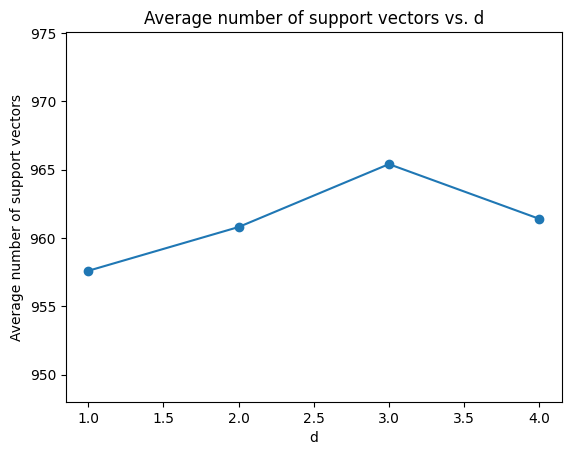

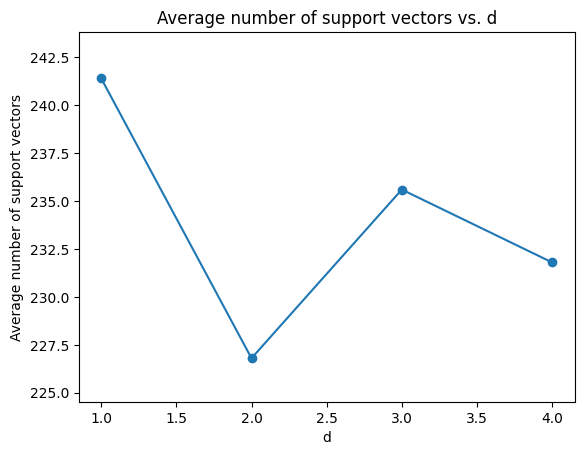

In [22]:
plot_avg_support_vec(SuppVect, d_vals)
plot_avg_violating_support_vec(vmd, d_vals)

################
################
# Q3 e
################
################

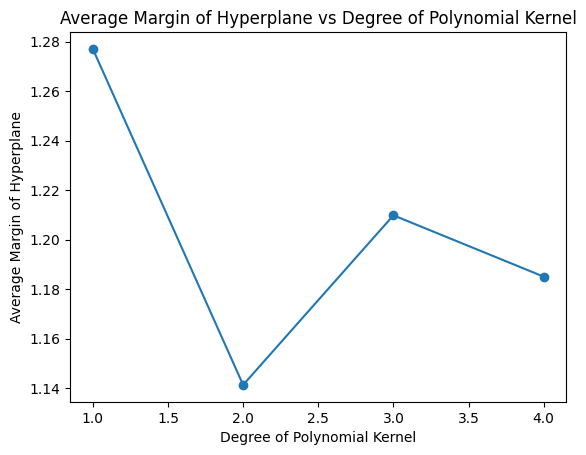

In [23]:
plot_avg_hyperplane_margins(MarginT, d_vals)